In [1]:
# data manipulation
import pandas as pd
import numpy as np
import itertools

# explore
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# nlp
import unicodedata
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk.sentiment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes as nb

# local
import wrangle as w

imports loaded successfully, awaiting commands...


# Acquire

In [2]:
# from google.oauth2 import service_account
# import pandas_gbq

# credentials = service_account.Credentials.from_service_account_file(
#     'my-ds-projects-d864a770b51b.json',
# )
# df = pandas_gbq.read_gbq("select * from cfpb_complaints.complaint_database",dialect='standard',project_id="my-ds-projects",use_bqstorage_api=True,credentials=credentials)
# df

In [49]:
df = w.check_file_exists_gbq('cfpb.csv','service_key.json')
df.head(5)

csv file found and loaded


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2020-12-29,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,AL,35405.0,NaN,Consent not provided,Web,2020-12-29,Closed with explanation,True,NaN,4038153
1,2022-07-30,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,MI,48033,NaN,Consent not provided,Web,2022-07-30,Closed with non-monetary relief,True,NaN,5826643
2,2020-03-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,PA,19134.0,NaN,Consent not provided,Web,2020-03-19,Closed with explanation,True,NaN,3573279
3,2018-08-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,KY,41101,Servicemember,Consent not provided,Web,2018-08-13,Closed with explanation,True,NaN,2990219
4,2019-11-20,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,NC,28166.0,NaN,Consent not provided,Web,2019-11-20,Closed with non-monetary relief,True,NaN,3444058


In [4]:
# df.info()

# Prepare

In [5]:
# df_clean = w.clean_data(df.copy())
# df_clean.head()

In [6]:
# df_clean.info()

In [7]:
pd.set_option('display.max_colwidth',None)

In [8]:
# df_clean_sample = prep_narrative(df_clean.head(10000))
# df_clean_sample[['narrative','clean','lemon']].head(1)

In [9]:
# all_words = [word for row in df_clean_sample['clean'] for word in row.split()]
# all_words = all_words.sort()

In [10]:
# type(all_words)

In [11]:
# all_words.sort()

In [12]:
# all_words

In [13]:
# sample_str = df_clean.narrative[0]
# sample_str

In [14]:
# sample_str_sub = re.sub(r'[X{1,}\d\']', ' ', string=sample_str)
# sample_str_sub

In [15]:
# sample_str_clean = basic_clean(sample_str_sub)
# sample_str_clean

In [16]:
# sample_str_token = token_it_up(sample_str_clean)
# sample_str_token

In [17]:
# sample_str_stop = remove_stopwords(sample_str_token,["&#9;", "12", "'"])
# sample_str_stop

In [18]:
# sample_str_lem = lemmad(sample_str_stop)
# sample_str_lem

In [19]:
# df_lem = w.prep_narrative(df_clean)
# df_lem.head(1)

In [20]:
# df_lem.to_parquet('df_lem.parquet')

In [21]:
df_lem = pd.read_parquet('df_lem.parquet')
df_lem.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
0,2021-08-09,"Afterpay US Services, LLC",MD,Average Person,Closed with explanation,money_service,on i filed a complaint and dispute with afterpay us services llc an international payment platform engaged in the pay later service per their installment agreement complaints and disputes that arise out of or related to the agreement should be filed through my complaint and dispute was in regards to a merchant that i placed an order with on the payment method for the order was through afterpay in my compliant with afterpay i noted that i had received a damaged order from the merchant and had reached out to the merchant for return instructions and a refund however the merchant failed to provide a return label as a result i was gong to have to pay on my payment due date of on i received a response from afterpay stating your afterpay payment plan remains in place we are not able to adjust your payment schedule on the basis of longer than expected delivery the response from afterpay also failed to indicate if they attempted to reach out to the merchant for a response it appears that was not done on i contacted afterpay and indicated that the basis of my dispute was not due to longer than expected delivery but had clearly indicated the merchant was failing to adhere to their return policy and did not honor the issuance of a return label on i received a response from the merchant that a return label would be sent to me on mysteriously this was the same date my installment payment was due it appears the merchant deliberately stalled the issuance of a return label in order to fraudulently collect funds that were in dispute as an international payment platform afterpay does not provide a claim process in which consumers are allowed to file a complaint against a merchant having such a process would allow for an investigation and response from the merchant instead consumers are forced to make payment and pay for goods they arent keeping dispute evidence that merchants have failed to adhere to their return policy,filed complaint dispute afterpay u service llc international payment platform engaged pay later service per installment agreement complaint dispute arise related agreement filed complaint dispute regard merchant placed order payment method order afterpay compliant afterpay noted received damaged order merchant reached merchant return instruction refund however merchant failed provide return label result gong pay payment due date received response afterpay stating afterpay payment plan remains place able adjust payment schedule basis longer expected delivery response afterpay also failed indicate attempted reach merchant response appears done contacted afterpay indicated basis dispute due longer expected delivery clearly indicated merchant failing adhere return policy honor issuance return label received response merchant return label would sent mysteriously date installment payment due appears merchant deliberately stalled issuance return label order fraudulently collect fund dispute international payment platform afterpay provide claim process consumer allowed file complaint merchant process would allow investigation response merchant instead consumer forced make payment pay good arent keeping dispute evidence merchant failed adhere return policy


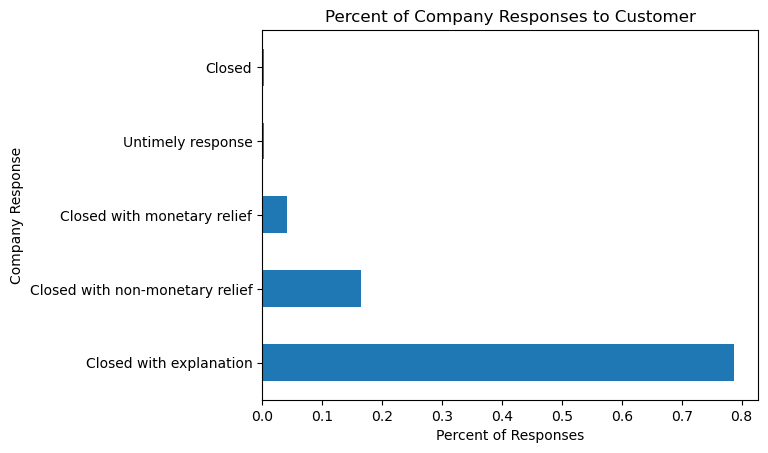

In [22]:
df_lem.company_response_to_consumer.value_counts(normalize=True).plot(
    kind='barh',
    title='Percent of Company Responses to Customer',
    xlabel='Percent of Responses',
    ylabel='Company Response');

In [23]:
df_lem.company_response_to_consumer.value_counts(normalize=True)

Closed with explanation            0.787889
Closed with non-monetary relief    0.164657
Closed with monetary relief        0.040877
Untimely response                  0.003577
Closed                             0.003001
Name: company_response_to_consumer, dtype: float64

In [24]:
# all_words = [word for row in df_lem['lemon'] for word in row.split()]
# all_words.sort()
# all_words

In [25]:
train, validate, test = w.split_data(df_lem,'company_response_to_consumer')

Prepared DF: (1246736, 8)
Train: (748041, 8)
Validate: (249347, 8)
Test: (249348, 8)


# Explore

In [26]:
train.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
875340,2017-12-25,JPMORGAN CHASE & CO.,CA,Average Person,Closed with monetary relief,credit_card,merchant charged my credit on in the amount of i called merchant to let them know i have already canceled my service merchant refunded full amount of on i wrote to chase bank and filed dispute chase removed the charge and then reposted in my account i even attached a copy of the receipt to show that merchant had refunded all credit i wrote to them a few times but never heard from them please help thank you,merchant charged credit amount called merchant let know already canceled service merchant refunded full amount wrote chase bank filed dispute chase removed charge reposted account even attached copy receipt show merchant refunded credit wrote time never heard please help thank


In [27]:
train.company_response_to_consumer.value_counts(normalize=True)

Closed with explanation            0.787889
Closed with non-monetary relief    0.164657
Closed with monetary relief        0.040877
Untimely response                  0.003576
Closed                             0.003001
Name: company_response_to_consumer, dtype: float64

In [28]:
validate.company_response_to_consumer.value_counts(normalize=True)

Closed with explanation            0.787890
Closed with non-monetary relief    0.164658
Closed with monetary relief        0.040875
Untimely response                  0.003577
Closed                             0.003000
Name: company_response_to_consumer, dtype: float64

In [29]:
test.company_response_to_consumer.value_counts(normalize=True)

Closed with explanation            0.787887
Closed with non-monetary relief    0.164657
Closed with monetary relief        0.040879
Untimely response                  0.003577
Closed                             0.003000
Name: company_response_to_consumer, dtype: float64

## 8.Which product is more likely to have monetary relief?

In [30]:
money = train[train.company_response_to_consumer=='Closed with monetary relief']
money.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
875340,2017-12-25,JPMORGAN CHASE & CO.,CA,Average Person,Closed with monetary relief,credit_card,merchant charged my credit on in the amount of i called merchant to let them know i have already canceled my service merchant refunded full amount of on i wrote to chase bank and filed dispute chase removed the charge and then reposted in my account i even attached a copy of the receipt to show that merchant had refunded all credit i wrote to them a few times but never heard from them please help thank you,merchant charged credit amount called merchant let know already canceled service merchant refunded full amount wrote chase bank filed dispute chase removed charge reposted account even attached copy receipt show merchant refunded credit wrote time never heard please help thank


In [31]:
money.product_bins.value_counts()

credit_card        13112
bank                9106
mortgage            2404
money_service       1927
loans               1845
credit_report       1152
debt_collection     1032
Name: product_bins, dtype: int64

In [32]:
money.product_bins.value_counts(normalize=True)

credit_card        0.428805
bank               0.297796
mortgage           0.078619
money_service      0.063019
loans              0.060337
credit_report      0.037674
debt_collection    0.033750
Name: product_bins, dtype: float64

In [33]:
cross = pd.crosstab(train['product_bins'],train['company_response_to_consumer'],normalize='index')
cross

company_response_to_consumer,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
product_bins,,,,,
bank,0.004587,0.746144,0.194270,0.054189,0.000811
credit_card,0.001112,0.693124,0.197069,0.107808,0.000887
credit_report,0.000130,0.754446,0.002999,0.241253,0.001172
debt_collection,0.010413,0.850581,0.008542,0.118047,0.012416
loans,0.003909,0.887134,0.037179,0.063134,0.008645
money_service,0.000374,0.830972,0.103043,0.062884,0.002727
mortgage,0.007278,0.914926,0.039142,0.036244,0.002410


In [34]:
cross['Closed with monetary relief'].sort_values()

product_bins
credit_report      0.002999
debt_collection    0.008542
loans              0.037179
mortgage           0.039142
money_service      0.103043
bank               0.194270
credit_card        0.197069
Name: Closed with monetary relief, dtype: float64

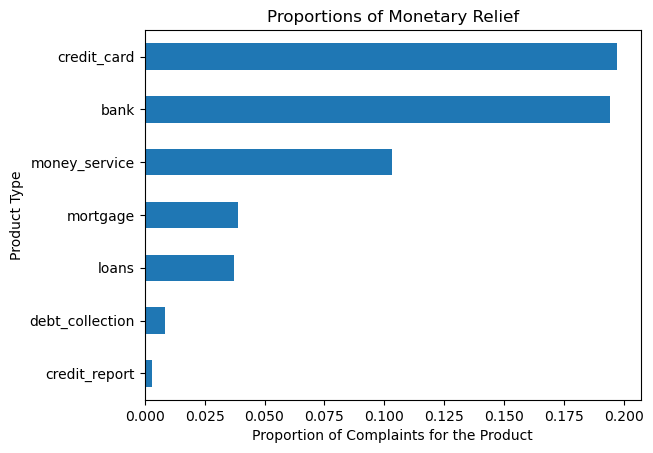

In [35]:
cross['Closed with monetary relief'].sort_values().plot(kind='barh', title='Proportions of Monetary Relief', xlabel='Proportion of Complaints for the Product', ylabel='Product Type');

In [36]:
# credit card and bank related products have the highest chance of getting monetary relief at just under 20%
# it makes sense that credit report products have the least chance of getting monetary relief

In [42]:
def monetary_product(train):
    # make crosstab of product and responses and normalize to get product proportions
    cross = pd.crosstab(train['product_bins'],train['company_response_to_consumer'],normalize='index')
    # plot monetary relief products
    cross['Closed with monetary relief'].sort_values(
        ).plot(kind='barh', 
                title='Proportions of Monetary Relief', 
                xlabel='Proportion of Complaints for the Product', 
                ylabel='Product Type');

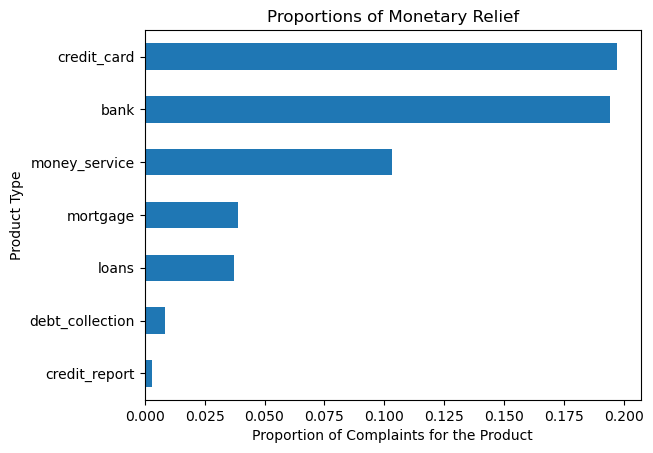

In [43]:
monetary_product(train)

## 9. Are there more complaints during certain seasons of the year?

In [44]:
# from datetime import datetime

In [45]:
# train.head(1)

In [46]:
# train['month'] = train.date_received.apply(lambda row: row.strftime("%m")).astype(str)
# train['year'] = train.date_received.apply(lambda row: row.strftime("%y")).astype(str)

In [47]:
# # Performed 1 aggregation grouped on columns: 'month', 'year'
# yearly = train.groupby(['month', 'year']).agg(year_count=('year', 'count'))

# # Performed 1 aggregation grouped on column: 'month'
# monthly = yearly.groupby(['month']).agg(year_count_mean=('year_count', 'mean'))

In [48]:
# train.groupby(['month']).agg(month_count=('month', 'count')).plot(kind='bar')

## Modeling